## Mercado Libre Tech Challenge Part 4: Time Series Forecasting

### Objetive: build a model to predict daily sales 21 days in the future using historical sales data.

### Imports & Utils

In [217]:
import pandas as pd
import numpy as np
from IPython.display import display
import xgboost as xgb
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from enum import Enum



TIME_COLUMNS = [
        "year",
        "month",
        "week_of_year",
        "day_of_week",
        "day_of_month",
        "day_of_year"
    ]

TARGET = "daily_sales"

BACKWARD_WINDOW_SIZE = 30  # Sales in this number of past days will be used as model feature.
FORWARD_WINDOW_SIZE = 21 # Sales will be predicted for this number of days in the future.


class ModelFeatures(Enum):
    NORMALIZED_TIME = [TARGET] + [f"{x}_norm" for x in TIME_COLUMNS]
    CYCLIC_TIME = [TARGET] + [f"{x}_sin" for x in TIME_COLUMNS] + [f"{x}_cos" for x in TIME_COLUMNS]
        


def add_cyclic_time(df: pd.DataFrame, time_column: str) -> pd.DataFrame:

    time_max = df[time_column].max()
    df[f"{time_column}_sin"] = df[time_column].transform(
        lambda x: np.sin((x - 1) * 2 * np.pi / time_max).astype(np.float64)
        )
    df[f"{time_column}_cos"] = df[time_column].transform(
        lambda x: np.cos((x - 1) * 2 * np.pi / time_max).astype(np.float64)
        )
    
    return df


def normalize_time(df: pd.DataFrame) -> pd.DataFrame:
    
    
        
    return df


def add_time_features(df: pd.DataFrame, time_normalize: bool, time_cyclic: bool) -> pd.DataFrame:
    
    df = pd.concat([df, df["DATE"].dt.isocalendar()],axis=1)
    df.rename(columns={"week": "week_of_year", "day": "day_of_week"}, inplace=True)
    
    df["day_of_month"] = df["DATE"].dt.day
    df["day_of_year"] = df["DATE"].dt.day_of_year
    df["month"] = df["DATE"].dt.month

    for time_col in TIME_COLUMNS:
        if time_cyclic:
            df = add_cyclic_time(df, time_column=time_col)
        if time_normalize:
            df[f"{time_col}_norm"] = minmax_scale(df[time_col], feature_range=(-0.5, 0.5))
                
    
    return df


def clean_up(df: pd.DataFrame) -> pd.DataFrame:
    
    # Clean duplicates
    num_dup = df.shape[0] - df.drop_duplicates().shape[0]
    print(f"Number of duplicate rows in dataset: {num_dup}")
    
    if num_dup > 0:
        print("Removing duplicates ...")
        print(f"Dataset number of rows before cleaning duplicates: {df.shape[0]}")
        df.drop_duplicates(inplace=True)
        print(f"Dataset number of rows after cleaning duplicates: {df.shape[0]}")
        
    # Drop outliers
    
    return df


def pre_process(df: pd.DataFrame, time_normalize:bool = False, time_cyclic:bool = False) -> pd.DataFrame:

    # Format date column
    df = df.astype({"DATE": np.datetime64})

    # Rename sales column
    df.rename(columns={"UNITS_SOLD": "daily_sales"}, inplace=True)
    
    # Add time features
    df = add_time_features(df=df, time_normalize=time_normalize, time_cyclic=time_cyclic)
    
    # Sort by date
    df.sort_values("DATE", ascending=True, inplace=True)
        
    return df


def split(df:pd.DataFrame, train_fraction: float = 0.7, val_fraction: float = 0.15) -> pd.DataFrame:
    
    df_size = df.shape[0]
    
    train_split_size = np.floor(df_size * train_fraction)
    train_split_size = int(train_split_size - (train_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    val_split_size = np.floor(df_size * val_fraction)
    val_split_size = int(val_split_size - (val_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    test_split_size = df_size - (train_split_size + val_split_size)
    test_split_size = int(test_split_size - (test_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    train_split_idx = train_split_size
    val_split_idx = train_split_idx + val_split_size
    test_split_idx = val_split_idx + test_split_size
    
    
    train_split = df.iloc[0:train_split_idx, :]
    val_split = df.iloc[train_split_idx:val_split_idx, :]
    test_split = df.iloc[val_split_idx:test_split_idx, :]
    
    return train_split, val_split, test_split
    
def generate_batches(df: pd.DataFrame):
    
   end=df.shape[0]
   start=0
   next=0
   x_batches=[]
   y_batches=[]  
   counter=0
   limit=max(BACKWARD_WINDOW_SIZE,FORWARD_WINDOW_SIZE)
   while next+(limit)<end:
        next=start+BACKWARD_WINDOW_SIZE
        x_batches.append(df[start:next,:])
        y_batches.append(df[next:next+FORWARD_WINDOW_SIZE,0])
        start=start+1
   y_batches=np.asarray(y_batches)
   y_batches = y_batches.reshape(-1, FORWARD_WINDOW_SIZE, 1) 
   x_batches=np.asarray(x_batches) 
   x_batches = x_batches.reshape(-1, BACKWARD_WINDOW_SIZE, len(ModelFeatures.NORMALIZED_TIME.value))
   
   return x_batches, y_batches
    

### Load data

In [186]:
data_path = "../data"
data_file_name = "series.csv"
data_raw = pd.read_csv(f"{data_path}/{data_file_name}")

print("Dataset info:")
print(f"{data_raw.info()}\n")

print("Dataset sample:")
display(data_raw.sample(10, random_state=152))

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB
None

Dataset sample:


,CATEGORY,DATE,UNITS_SOLD
136,CATEG-3,2021-05-07,2559
452,CATEG-3,2021-08-14,2085
181,CATEG-1,2021-03-05,77
528,CATEG-2,2021-06-06,42
2477,CATEG-2,2020-12-14,24
1951,CATEG-2,2021-08-23,28
316,CATEG-2,2020-02-17,7
2285,CATEG-3,2020-04-17,861
1383,CATEG-3,2021-01-28,2136
179,CATEG-2,2020-11-06,4


In [192]:
data_clean = clean_up(df=data_raw)

data = pre_process(df=data_clean, time_normalize=True, time_cyclic=True)

train_set, val_set, test_set = split(df=data, train_fraction=0.8, val_fraction=0)

Number of duplicate rows in dataset: 0


In [219]:
x_batches, y_batches = generate_batches(df=train_set)

InvalidIndexError: (slice(0, 30, None), slice(None, None, None))

In [151]:
data[["CATEGORY", "daily_sales"]].groupby("CATEGORY").describe()

daily_sales                                                       \
               count         mean         std  min    25%     50%     75%   
CATEGORY                                                                    
CATEG-1        887.0    53.130778   31.921476  1.0   31.0    47.0    65.0   
CATEG-2        879.0    44.747440   59.467396  1.0    9.0    19.0    51.5   
CATEG-3        920.0  1457.304348  869.635335  0.0  675.0  1452.0  2015.0   

                  
             max  
CATEGORY          
CATEG-1    210.0  
CATEG-2    332.0  
CATEG-3   7551.0

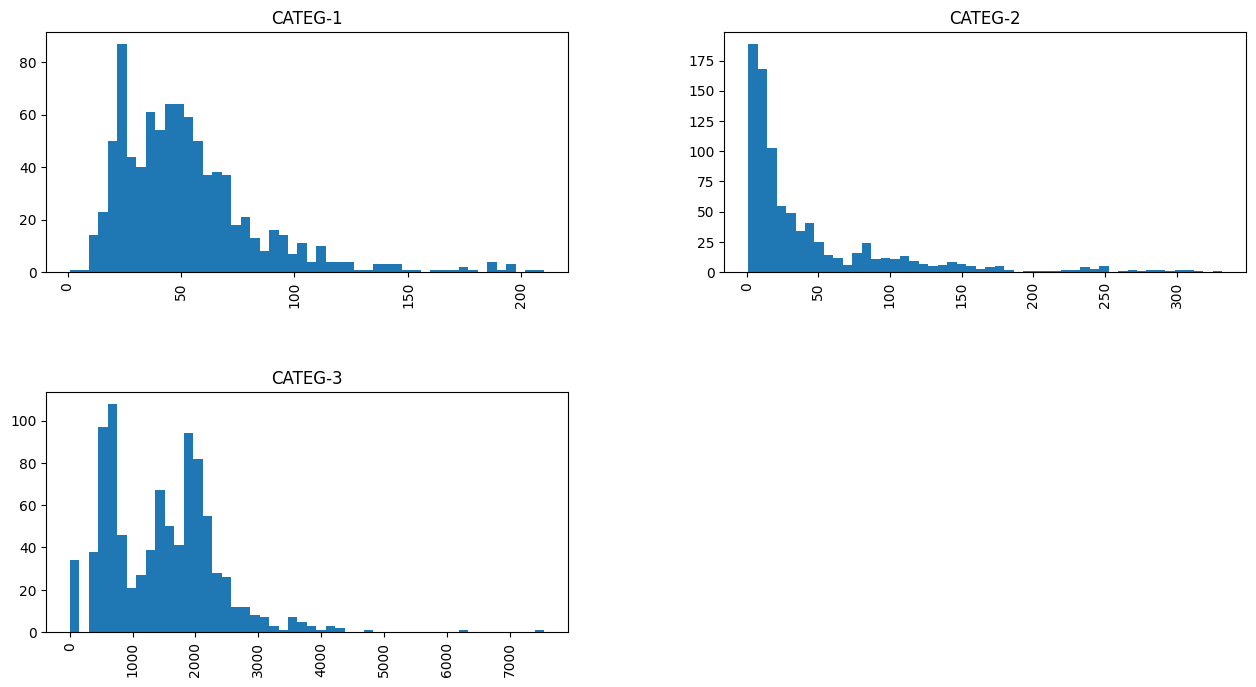

In [154]:
h = data[["CATEGORY", "daily_sales"]].hist(by="CATEGORY", figsize=(15,8), bins=50)

In [155]:
data[["CATEGORY", "DATE"]].groupby("CATEGORY").agg(["min","max"])

DATE           
                min        max
CATEGORY                      
CATEG-1  2018-10-16 2021-11-12
CATEG-2  2018-10-16 2021-11-12
CATEG-3  2018-09-24 2021-11-12

In [156]:
data.iloc[:,1:]

,DATE,daily_sales,year,week_of_year,day_of_week,day_of_month,day_of_year,month
0,2021-08-17,59,2021,33,2,17,229,8
1,2020-09-19,40,2020,38,6,19,263,9
2,2021-10-26,23,2021,43,2,26,299,10
3,2021-04-27,60,2021,17,2,27,117,4
4,2021-05-05,61,2021,18,3,5,125,5
...,...,...,...,...,...,...,...,...
2681,2021-02-18,78,2021,7,4,18,49,2
2682,2020-12-05,8,2020,49,6,5,340,12
2683,2020-02-05,3,2020,6,3,5,36,2
2684,2020-06-05,106,2020,23,5,5,157,6


In [157]:
data

,CATEGORY,DATE,daily_sales,year,week_of_year,day_of_week,day_of_month,day_of_year,month
0,CATEG-1,2021-08-17,59,2021,33,2,17,229,8
1,CATEG-1,2020-09-19,40,2020,38,6,19,263,9
2,CATEG-2,2021-10-26,23,2021,43,2,26,299,10
3,CATEG-1,2021-04-27,60,2021,17,2,27,117,4
4,CATEG-2,2021-05-05,61,2021,18,3,5,125,5
...,...,...,...,...,...,...,...,...,...
2681,CATEG-1,2021-02-18,78,2021,7,4,18,49,2
2682,CATEG-2,2020-12-05,8,2020,49,6,5,340,12
2683,CATEG-2,2020-02-05,3,2020,6,3,5,36,2
2684,CATEG-2,2020-06-05,106,2020,23,5,5,157,6
